## Spatial Variogram

#### Mark Gibbs, Gibbs Consulting

One of the key inputs to a [Kriging](https://en.wikipedia.org/wiki/Kriging) estimation is the [variogram](https://en.wikipedia.org/wiki/Variogram) describing the covariance between separate points as a function of separation. Characterising this variogram is often one of the more time consuming parts of the estimation process.

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
from scipy import stats

Create some random test data.

In [2]:
x_len,y_len = (87,62)
x_grid = np.array(range(x_len))
y_grid = np.array(range(y_len))

In [3]:
shp = (x_len,y_len)
noise = np.random.standard_normal(size=shp)
xv,yv = np.meshgrid(x_grid,y_grid)
glocs = [
    (7,19,45,101),
    (57,19,105,301),
    (37,59,15,501),
    (77,19,95,200),
]
def calc_gaussian(gloc,xv,yv):
    x,y,scale,var = gloc
    dists = (xv-x)**2 + (yv-y)**2
    return scale * np.exp( (-1.0/(2.0*var)) * dists)
vht = 9 * noise.T
for gloc in glocs:
    vht = vht + calc_gaussian(gloc,xv,yv)
vht = vht + 98
vht = vht.T

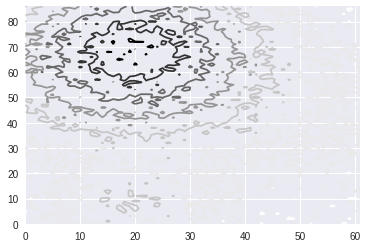

In [4]:
plt.contour(vht)

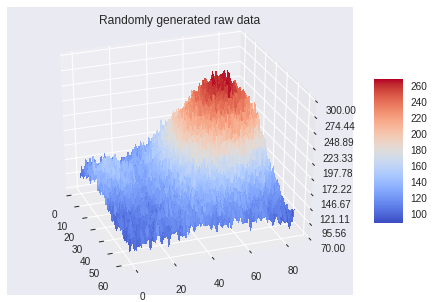

In [5]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(x_grid,y_grid)
Z = np.sqrt(vht * vht).T

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(Y, X, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(70, 300.0)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.view_init(30,-20)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Randomly generated raw data')
plt.show()

A variogram is defined as

$$\gamma(h) = \int_V \left( f(x+h) - f(x) \right)^2 {\mathrm{d}}x$$

where the integral is over the volume $V$ of points at a distance $h$. Here, as is generally the case, the variogram has to be estimated empirically from observations. Here, random samples are taken from the regular grid; this is somewhat different from the common geostatistical use case where the locations of measurements are in general not on such rigid spacing.

In [6]:
import random

svg = []
for i in range(200):
    x = random.randint(1,x_len)-1
    y = random.randint(1,y_len)-1
    v = np.array([x,y])
    a = vht[x,y]
    for j in range(1000):
        x2 = random.randint(1,x_len)-1
        y2 = random.randint(1,y_len)-1
        v2 = np.array([x2,y2])
        a2 = vht[x2,y2]
        vd = v2 - v
        h = np.dot(vd,vd)
        ad = a2 - a
        svg.append([x,y,x2,y2,a,a2,h,np.sqrt(h),ad,ad*ad])
                

In [7]:
dfSamples = pd.DataFrame(svg,columns=['x1','y1','x2','y2','a1','a2','distsq','dist','deviate','dsq'])
dfSamples['distance'] = dfSamples['dist']
dfSamples['Unit'] = 1

In [8]:
dfSamples[:6]

,x1,y1,x2,y2,a1,a2,distsq,dist,deviate,dsq,distance,Unit
0,84,6,70,34,170.464652,199.596915,980,31.304952,29.132263,848.688748,31.304952,1
1,84,6,12,35,170.464652,107.353869,6025,77.620873,-63.110783,3982.970970,77.620873,1
2,84,6,68,48,170.464652,127.452446,2020,44.944410,-43.012207,1850.049940,44.944410,1
3,84,6,51,22,170.464652,206.088023,1345,36.674242,35.623371,1269.024531,36.674242,1
4,84,6,82,57,170.464652,105.273286,2605,51.039201,-65.191366,4249.914197,51.039201,1
5,84,6,7,0,170.464652,104.706812,5965,77.233412,-65.757841,4324.093591,77.233412,1


Binning the individual samples allows the empirical variogram to be formed.

In [9]:
xBins = pd.cut(dfSamples['dist'],bins=40)

In [10]:
binnedVar = dfSamples.groupby(xBins).agg({'dsq':np.mean,'Unit':np.sum,'distance':np.mean})
bVar = binnedVar.reset_index()
bVar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
dist        40 non-null category
dsq         40 non-null float64
Unit        40 non-null int64
distance    40 non-null float64
dtypes: category(1), float64(2), int64(1)
memory usage: 1.4 KB


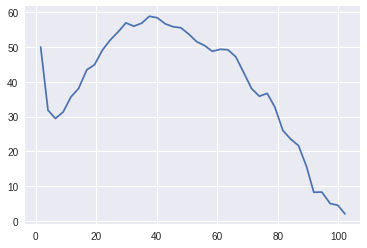

In [11]:
plt.plot(bVar['distance'],bVar['dsq']*0.5/bVar['distance'])


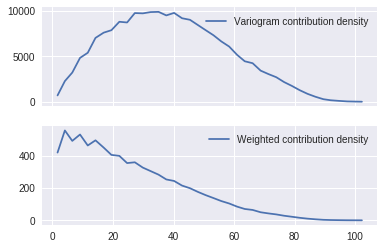

In [12]:
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(bVar['distance'],bVar['Unit'],label="Variogram contribution density")
ax[1].plot(bVar['distance'],bVar['Unit']/bVar['distance'],label="Weighted contribution density")
for axe in ax:
    axe.legend()

The limited statistics at both short distances and longer distances can be seen. The sampling approach used picks pairs of points at random throughout the grid, so both are to be expected. Firstly, very few points are close to each other. Secondly, longer distances are curtailed by the finite extent of the grid.

In [13]:
N = 25
distances = bVar['distance'][3:N]
variances = bVar['dsq'][3:N]

bVar.head()

,dist,dsq,Unit,distance
0,"(-0.104, 2.595]",168.118416,704,1.680088
1,"(2.595, 5.191]",261.093166,2279,4.101053
2,"(5.191, 7.786]",385.597522,3217,6.549132
3,"(7.786, 10.381]",570.214469,4832,9.106215
4,"(10.381, 12.977]",830.713235,5396,11.660951


In [14]:
def variogram(d,a,b):
    return a * (np.tanh(d/b))

def vg_func(a,b):
    def this_variogram(d):
        return variogram(d,a=a,b=b)
    return this_variogram

In [15]:
tFunc = vg_func(50,15)

def gen_plot(f):
    vdf = pd.DataFrame({'XVals':distances,'YVars':variances*0.5/distances})
    vdf['YVals'] = vdf['XVals'].apply(f)
    return vdf

,XVals,YVars,YVals
count,22.000000,22.000000,22.000000
mean,36.330551,50.343011,46.033450
std,16.847343,7.559951,6.332951
min,9.106215,31.309082,27.103454
25%,22.741331,48.884026,45.359192
50%,36.326309,51.804774,49.206986
75%,49.951958,55.978834,49.870572
max,63.532166,58.893085,49.979058


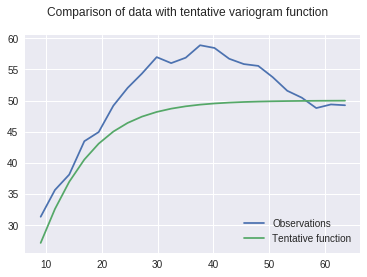

In [16]:
p = gen_plot(tFunc)
plt.plot(p['XVals'],p['YVars'],label="Observations")
plt.plot(p['XVals'],p['YVals'],label="Tentative function")
plt.suptitle("Comparison of data with tentative variogram function")
plt.legend()
p.describe()

In [17]:
from scipy.optimize import curve_fit

In [18]:
cf = curve_fit(variogram,xdata=p['XVals'],ydata=p['YVars'],p0=(50,15))
a = cf[0][0]
b = cf[0][1]
print(cf)

(array([ 54.4516847,  14.5794481]), array([[ 0.90289709,  0.62072812],
       [ 0.62072812,  1.23508994]]))


,XVals,YVars,YVals
count,22.000000,22.000000,22.000000
mean,36.330551,50.343011,50.360820
std,16.847343,7.559951,6.671259
min,9.106215,31.309082,30.183524
25%,22.741331,48.884026,49.800179
50%,36.326309,51.804774,53.699249
75%,49.951958,55.978834,54.335261
max,63.532166,58.893085,54.433821


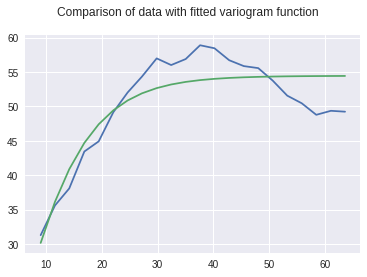

In [19]:
fittedVariogram = vg_func(a,b)

p = gen_plot(fittedVariogram)
plt.plot(p['XVals'],p['YVars'],label="Observations")
plt.plot(p['XVals'],p['YVals'],label="Fitted variogram")
plt.suptitle("Comparison of data with fitted variogram function")
p.describe()

The range of bins used was somewhat arbitrary. Keeping the initial cut at the first three bins to dispose of any short-distance noise - more study here is the different topic of the nugget effect - and varying the number of bins used allows the impact of this choice to be investigated.

In [20]:
def fit_at_N(N):
    distances = bVar['distance'][3:N]
    variances = bVar['dsq'][3:N]
    cf = curve_fit(variogram,xdata=distances,ydata=variances*0.5/distances,p0=(50,15))
    a = cf[0][0]
    b = cf[0][1]
    return (a,b)

In [21]:
fits = []
for n in range(9,38):
    a, b =fit_at_N(n)
    fits.append([n,a,b])
dfFits = pd.DataFrame(fits,columns=["N","A","B"])

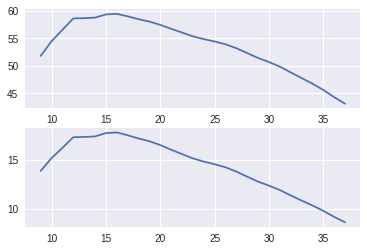

In [22]:
fig, axes = plt.subplots(nrows=2)

axes[0].plot(dfFits['N'],dfFits['A'])
axes[1].plot(dfFits['N'],dfFits['B'])


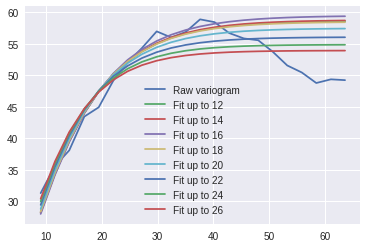

In [23]:
plt.plot(distances, variances*0.5/distances, label="Raw variogram")

for N in range(12,27,2):
    row = dfFits[dfFits['N']==N]
    a = row['A']
    b = row['B']
    fittedVariogram = vg_func(a,b)

    p = gen_plot(fittedVariogram)
    plt.plot(p['XVals'],p['YVals'],label="Fit up to %i"%N)

plt.legend()

Recall that the goal of estimating the variogram is to provide an input to the actual function estimation process. Crudely, the variogram is used to determine the relative weights of different observations when determining an interpolated value for a location situated between observations. From the above it is reasonable to assume that the specific number of bins used is not critical.